In [1]:
import numpy as np
from calibration import placeinducingpoints, CalibrationSystem, SparseModel
import gpflow
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

## Simple Scaling Demo

Just two sensors, the low-cost sensor varies between 50% and 150% of the true sensor.
The latent function models the log scaling of the low-cost sensor.

In [2]:
X = np.c_[np.linspace(0,20,2001),np.zeros(2001),np.ones(2001)]
y = np.cos(X[:,0])*25+100
Y = np.c_[y,y*(0.5+0.1*X[:,0])]
refsensor = np.array([1,0])
Z = np.linspace(0,20,5)[:,None]

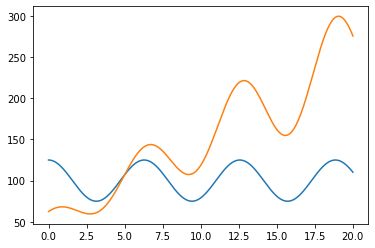

In [3]:
plt.plot(X[:,0],Y[:,0])
plt.plot(X[:,0],Y[:,1])

In [4]:
def transform_fn(samps,Y,sideY):
    return Y*tf.exp(samps[:,:,0:1])

k = gpflow.kernels.RBF(1,15)+gpflow.kernels.Bias(1)
kernelindices = [[0]*len(refsensor)]*1
cs = CalibrationSystem(X, Y, Z, refsensor, 1, transform_fn, [k],kernelindices,likelihoodstd=0.01,lr=0.05,minibatchsize=20)
#cs = CalibrationSystemNoMiniBatch(X, Y, Z, refsensor, 1, transform_fn, k,likelihoodstd=0.01,lr=0.05)
import time
st = time.time()
elbo_record = cs.run(its=200)
print(time.time()-st)

W0804 12:24:38.660019 140337902704384 deprecation.py:323] From /home/mike/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/distributions/distribution.py:284: MultivariateNormalFullCovariance.__init__ (from tensorflow_probability.python.distributions.mvn_full_covariance) is deprecated and will be removed after 2019-12-01.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Starting Run
....................20 (ELBO=19733331968.0000)
....................40 (ELBO=8853963776.0000)
....................60 (ELBO=5290192384.0000)
....................80 (ELBO=2618073856.0000)
....................100 (ELBO=2564163584.0000)
....................120 (ELBO=994550208.0000)
....................140 (ELBO=438463104.0000)
....................160 (ELBO=394475104.0000)
....................180 (ELBO=242160640.0000)
....................200 (ELBO=192105984.0000)
10.150411128997803


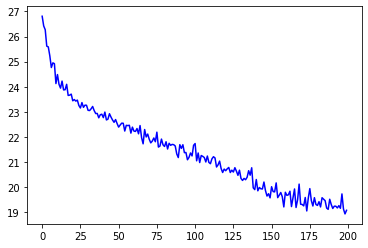

In [5]:
plt.plot(np.log(elbo_record),'b-')

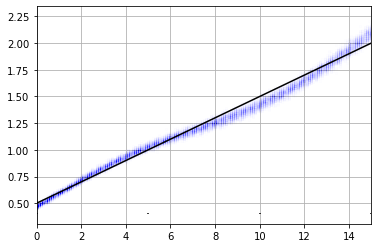

In [6]:
#build test matrix
C = 1
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,15,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,cs.k)
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)

    plt.figure(figsize=[6,4])
    plt.plot(x,1/tf.exp(samps[:,:,0].numpy().T),'b.',alpha=0.0025);
    plt.grid()
    plt.vlines(Z[:,0],.4,.41)
    plt.xlim([0,15])
    #plt.hlines(0.5,0,15,'k',label='scale')
    plt.plot([0,15],[0.5+0,0.5+0.1*15],'k-')
    #plt.legend(loc='lower left')

## Likelihood Model Demo

Here we have two sensors (reference and a permanently colocated static sensor). We add varying amounts of noise to the 2nd sensor. This is handled by the model.

In this example we use a different transform_fn that arguably isn't as sensible, with a scaling of 1+latent function. This clearly has issues as it allows negative scalings and treats an increase of 1.5x as equivalent in magnitude to a decrease of x0.5. While in reality one would expect 2x and 0.5x to be equivalent.

In [7]:
N = 501
X = np.linspace(0,260,N)[:,None]
X = np.c_[X,np.zeros(N),np.ones(N)]
Y = np.c_[np.linspace(20,40,N)[:,None],np.linspace(40,80,N)[:,None]]
Y[:,1]*=np.cos(X[:,0]/10)*0.2+1
Y[50:70,1]+=np.random.randn(20)*np.linspace(0,10,20)
Y[70:90,1]+=np.random.randn(20)*np.linspace(10,0,20)
Y[200:250,1]+=np.random.randn(50)*np.linspace(0,30,50)
Y[250:300,1]+=np.random.randn(50)*np.linspace(30,0,50)
Y[:,1]+=np.random.randn(N)*np.linspace(3,0,N)
refsensor = np.array([1,0])
Z = np.linspace(0,260,50)[:,None]

In [8]:
def transform_fn(samps,Y,sideY):
    return Y*(1+samps[:,:,0:1])

In [11]:
k = gpflow.kernels.RBF(100,20)+gpflow.kernels.Bias(100)
kernelindices = [[0]*len(refsensor)]*1

klike = gpflow.kernels.RBF(100,20)+gpflow.kernels.Bias(100)



cs = CalibrationSystem(X, Y, Z, refsensor, 1, transform_fn, [k], kernelindices, likemodel='distribution',gpflowkernellike=klike,likelihoodstd=0.5,minibatchsize=120)
import time
before = time.time()
elbo_record = cs.run(1000)
print(time.time()-before)

Starting Run
....................20 (ELBO=456804.9062)
....................40 (ELBO=195757.2344)
....................60 (ELBO=97147.5938)
....................80 (ELBO=45814.0508)
....................100 (ELBO=40450.0742)
....................120 (ELBO=21700.4629)
....................140 (ELBO=18000.8613)
....................160 (ELBO=13447.1748)
....................180 (ELBO=10854.1689)
....................200 (ELBO=9629.6387)
....................220 (ELBO=6406.4585)
....................240 (ELBO=5486.2529)
....................260 (ELBO=5066.0449)
....................280 (ELBO=4621.2808)
....................300 (ELBO=4624.2715)
....................320 (ELBO=3322.0615)
....................340 (ELBO=3208.6289)
....................360 (ELBO=2977.5352)
....................380 (ELBO=2461.3279)
....................400 (ELBO=2735.8040)
....................420 (ELBO=2153.7007)
....................440 (ELBO=2216.7395)
....................460 (ELBO=2073.3196)
....................480 (ELBO=2015.79

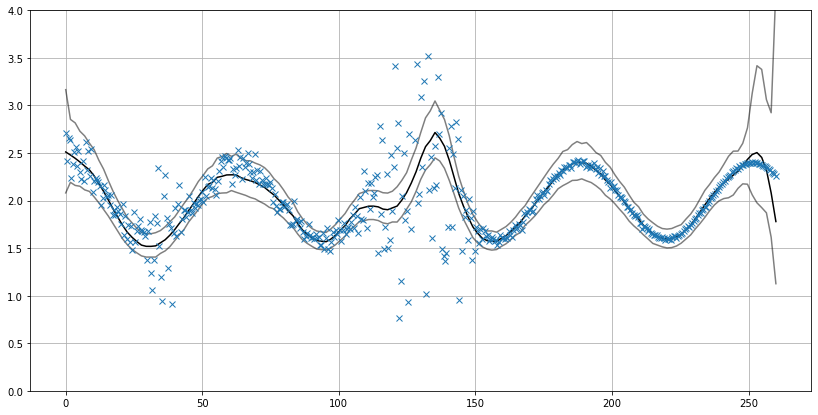

In [12]:
#build test matrix
C = 1
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,260,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,cs.k)
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    plt.figure(figsize=[14,7])
    plt.plot(x,1/(1+qf_mu[:151,0]),'k-')
    
    #plt.plot(x,1/(1+(qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0])),'k--',alpha=0.5)
    plt.plot(x,1/(1+(qf_mu[:151,0]-2*np.sqrt(np.diag(qf_cov)[:151]))),'k-',alpha=0.5)
    plt.plot(x,1/(1+(qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))),'k-',alpha=0.5)

    plt.plot(X[:,0],Y[:,1]/Y[:,0],'x')
    plt.ylim([0,4])
    plt.grid()

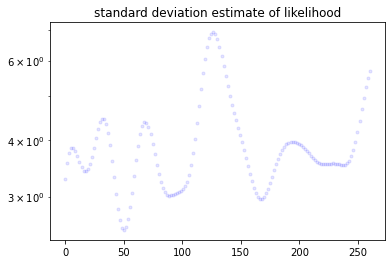

In [13]:
plt.title('standard deviation estimate of likelihood')
plt.plot(x,np.sqrt(np.exp(sampslike[:,:,0].numpy().T)),'b.',alpha=0.1);
plt.gca().set_yscale('log')
#plt.ylim([1e-3,1])

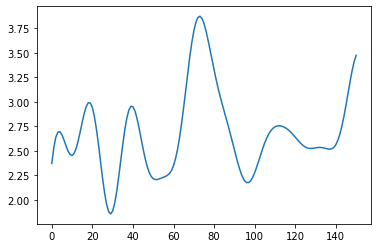

In [14]:
plt.plot(qf_mulike.numpy())

## Linear transform demo

Just two sensors, the low-cost sensor has a drift in which its offset increases over time.

There is obviously some ambiguity from the model's point of view as to whether the difference between the sensors is due scaling or offset.

In [15]:
X = np.c_[np.linspace(0,20,21),np.zeros(21),np.ones(21)]
y = np.cos(X[:,0])*25+100
Y = np.c_[y,y+X[:,0]]
refsensor = np.array([1,0])
Z = np.linspace(0,20,5)[:,None]

In [16]:
#def transform_fn(samps,Y):
#    return 100*(samps[:,:,0:1]) + Y*samps[:,:,1:2] + (samps[:,:,2:3]*Y**2)/1000

def transform_fn(samps,Y,sideY):
    return 100*samps[:,:,0:1] + Y*samps[:,:,1:2]
    #return 100*samps[:,:,0:1] + Y*tf.exp(samps[:,:,1:2])

#ks = [gpflow.kernels.RBF(1,15)+gpflow.kernels.Bias(1)]
#kernelindices = [[0]*len(refsensor)]*2
#if we know the lengthscale of the scaling is larger, then we can help the model..
ks = [gpflow.kernels.RBF(1,15)+gpflow.kernels.Bias(1),gpflow.kernels.Bias(1)]
kernelindices = [[0]*len(refsensor),[1]*len(refsensor)]

cs = CalibrationSystem(X, Y, Z, refsensor, 2, transform_fn, ks, kernelindices,likelihoodstd=0.001,lr=0.5)
elbo_record = cs.run(its=150)

Starting Run
....................20 (ELBO=33771700224.0000)
....................40 (ELBO=21395873792.0000)
....................60 (ELBO=12953735168.0000)
....................80 (ELBO=7118708224.0000)
....................100 (ELBO=3042632960.0000)
....................120 (ELBO=2026322304.0000)
....................140 (ELBO=1481245312.0000)
..........

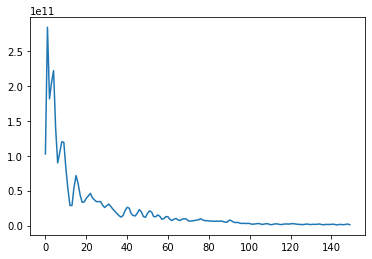

In [17]:
plt.plot(elbo_record)
#plt.ylim([0,300000000])

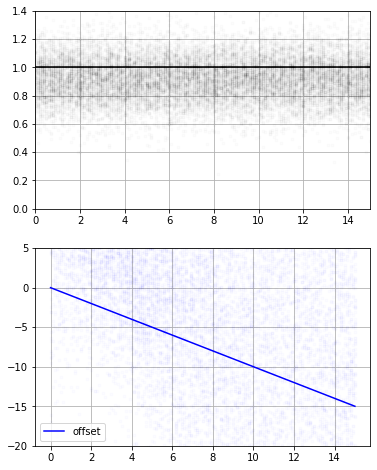

In [18]:
#build test matrix
C = 2
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,15,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,cs.k)
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)

    plt.figure(figsize=[6,8])
    plt.subplot(2,1,1)
    plt.plot(x,samps[:,:,1].numpy().T,'k.',alpha=0.01);
    plt.hlines(1,0,15,'k',label='scale')
    #plt.plot(-getsensorshift(x,np.ones_like(x).astype(int)))
    plt.grid()
    plt.vlines(Z[:,0],-.3,-.2)
    #plt.ylim([-20,2])
    plt.xlim([0,15])
    plt.ylim([0,1.4])
    plt.subplot(2,1,2)
    plt.grid()
    plt.plot([0,15],[0,-15],'b-',label='offset')
    plt.plot(x,100*samps[:,:,0].numpy().T,'b.',alpha=0.01);
    plt.legend(loc='lower left')
    plt.ylim([-20,5])

# Passing on the calibration

In [19]:
import numpy as np
from calibration import placeinducingpoints, CalibrationSystem, SparseModel
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
X = 1.0*np.array([[0,0,1],
              [1,0,2],
              [2,0,1],
              [3,0,2],
              [4,0,1],
              [5,0,2],
              [6,0,1],
              [7,0,2],
              [8,1,3],
              [9,0,2],
             [10,1,3],
             [11,0,2],
             [12,1,3],
             [13,2,4],
             [14,1,3],
             [15,2,4],
             [16,1,3],
             [17,2,4],
             [18,3,5],
             [19,2,4],
             [20,3,5],
             [21,4,5],
             [22,3,5],
             [23,4,5],
             [24,3,5],
             [30,0,5],
             [32,0,5],
             [34,0,5]])
N = len(X)
Y = np.c_[(3.0+X[:,1])*10,(3.0+X[:,2])*10]+np.random.randn(N,2)*0.1
refsensor = np.array([1,0,0,0,0,0])
Z = np.linspace(0,35,7)[:,None]

In [21]:
np.c_[X,Y]

array([[ 0.        ,  0.        ,  1.        , 30.1215984 , 40.17953322],
       [ 1.        ,  0.        ,  2.        , 29.94649435, 50.16279546],
       [ 2.        ,  0.        ,  1.        , 29.85288378, 40.04948823],
       [ 3.        ,  0.        ,  2.        , 30.07816741, 49.92344795],
       [ 4.        ,  0.        ,  1.        , 29.88019   , 40.20086407],
       [ 5.        ,  0.        ,  2.        , 29.89801037, 49.90900284],
       [ 6.        ,  0.        ,  1.        , 29.92481186, 39.89703892],
       [ 7.        ,  0.        ,  2.        , 30.26913668, 50.05457815],
       [ 8.        ,  1.        ,  3.        , 39.89621969, 59.91761536],
       [ 9.        ,  0.        ,  2.        , 29.967074  , 50.04550478],
       [10.        ,  1.        ,  3.        , 40.10947763, 59.9348231 ],
       [11.        ,  0.        ,  2.        , 29.90587487, 49.9587511 ],
       [12.        ,  1.        ,  3.        , 40.01442458, 60.10813348],
       [13.        ,  2.        ,  4. 

In [22]:
def transform_fn(samps,Y,sideY):
    return Y*tf.exp(samps[:,:,0:1])
k = gpflow.kernels.RBF(1.0,20)+gpflow.kernels.Bias(2.0)
kernelindices = [[0]*len(refsensor)]*1
cs = CalibrationSystem(X, Y, Z, refsensor, 1, transform_fn, [k],kernelindices,likelihoodstd=0.2,lr=0.01)
import time
before = time.time()
elbo_record = cs.run(2000)
print(time.time()-before)

Starting Run
....................20 (ELBO=925393.0000)
....................40 (ELBO=443079.2500)
....................60 (ELBO=328712.5938)
....................80 (ELBO=223403.9531)
....................100 (ELBO=169273.3906)
....................120 (ELBO=132977.4688)
....................140 (ELBO=102332.6250)
....................160 (ELBO=96023.1562)
....................180 (ELBO=77300.4844)
....................200 (ELBO=67198.2344)
....................220 (ELBO=60301.5859)
....................240 (ELBO=52402.5859)
....................260 (ELBO=47759.5391)
....................280 (ELBO=42580.4492)
....................300 (ELBO=37494.8125)
....................320 (ELBO=33131.7383)
....................340 (ELBO=30721.1094)
....................360 (ELBO=27706.6797)
....................380 (ELBO=24411.3398)
....................400 (ELBO=22657.7930)
....................420 (ELBO=19896.5977)
....................440 (ELBO=17743.3457)
....................460 (ELBO=16372.8379)
..................

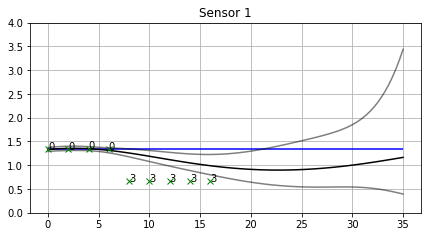

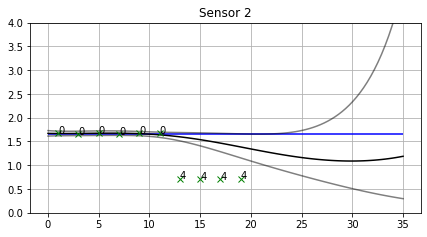

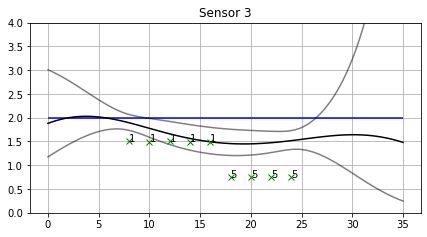

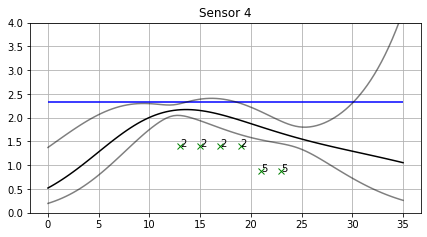

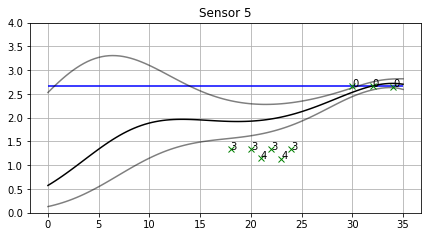

In [24]:
C = 1
Ttotal = 35
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,Ttotal,100)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,cs.k)
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    plt.figure(figsize=[7,3.5])
    #plt.plot(x,1/(1+qf_mu[:,0]),'k-')
    plt.plot(x,1/tf.exp(qf_mu[:,0]),'k-')
    #plt.plot(x,1/(1+qf_mu[:151,0])+2*np.sqrt(np.diag(qf_cov)[:151])+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0]),'k--',alpha=0.5)
    #plt.plot(x,1/(1+qf_mu[:151,0])-2*np.sqrt(np.diag(qf_cov)[:151])-2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0]),'k--',alpha=0.5)
    #plt.plot(x,1/(1+(qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0])),'k--',alpha=0.5)
    #r = (1/(1+(qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:])))).numpy()
    #r[r<0] = np.nan
    #plt.plot(x,r,'k-',alpha=0.5)
    #plt.plot(x,1/(1+(qf_mu[:,0]+2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]+2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    
    senseX = (X[:,1]==si)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'xg')
    for x,y in zip(X[senseX,:],Y[senseX,:]):
        plt.text(x[0],y[0]/y[1],"%d" % x[2])
    senseX = (X[:,2]==si)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'xg')
    for x,y in zip(X[senseX,:],Y[senseX,:]):
        plt.text(x[0],y[1]/y[0],"%d" % x[1])
    plt.hlines((3.0+si)/3.0,0,35,'b')
    plt.ylim([0,4])
    #plt.ylim([0.5,10])
    #plt.yscale('log')
    plt.grid()
    plt.title("Sensor %d"  % si)